# 🌋[EDA] Vesuvius Challenge - Ink Detection
---
**Welcome to my first notebook for the [Ink Detection competition](https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/overview).** As is customary when beginning a competition, it's important to understand what data are available. By exploring and familiarizing ourselves with the data, we can use them more effectively and gain a better understanding of what we're doing. In this notebook, I will be performing this preliminary work.

**[Here](https://www.youtube.com/watch?v=PpNq2cFotyY) is an interesting introduction video about the project.**

<a href="https://zupimages.net/viewer.php?id=23/12/esn8.png"><img src="https://zupimages.net/up/23/12/esn8.png" alt="" /></a>
<figcaption><u>Midjourney generation</u></figcaption>

## About the competition
The project aims to resurrect an ancient library that was **buried under the ashes of the Vesuvius volcano** nearly 2000 years ago. The library was located in a Roman villa in **Herculaneum**, a town near Pompeii, and contained thousands of scrolls. However, due to the extreme heat of the Vesuvius eruption, **the scrolls were carbonized** and have remained **unreadable** ever since. The competition requires participants to use **3D X-ray scans** to detect ink and read the contents of the scrolls. The discovery of these scrolls several hundred years ago has led to the quest to read them using modern techniques.

The goal of the competition is to produce a **binary image** of the same size as the scanned scrolls, where the ink pixels are represented by 1. This is a segmentation task, and the score will be calculated using the **[Sørensen–Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)**, which is essentially the F1-score.

We hope that this segmentation will help **reveal the knowledge** contained in the ancient texts.

**Let's get started!**

# Imports

In [1]:
!pip install celluloid -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from IPython.display import HTML, display

from celluloid import Camera
from tqdm.notebook import tqdm
import gc
import seaborn as sns

# Function to display the scan layers (volume)
The following functions create a video to visualize the contents of a given papyrus scroll by combining the scans from the dataset. The dataset contains 5 different scans:
- **Train: 1 / 2 / 3**
- **Test: a / b**

The `display_volume` function uses those values.

Thanks to *Leonid Kulyk* for inspiring me this function: [Source](https://www.kaggle.com/code/leonidkulyk/eda-vc-id-volume-layers-animation/notebook)

In [3]:
N_SCAN_LAYERS = 65

# Load the volume of the given papyrus scroll
def load_volume(set_name, folder_name):
    path = f'/kaggle/input/vesuvius-challenge-ink-detection/{set_name}/{folder_name}/surface_volume'
    file_format = "{:02d}.tif"
    volume = []
    
    for i in tqdm(range(N_SCAN_LAYERS)):
        file = f'{path}/{file_format.format(i)}'
        img = cv2.imread(file, cv2.IMREAD_ANYDEPTH)
        volume.append(img)
        
    return volume

# Display the volume as a video
def display_volume(set_name, folder_name):
    volume = load_volume(set_name, folder_name)
    fig, ax = plt.subplots()
    camera = Camera(fig)
    
    for i in range(N_SCAN_LAYERS):
        ax.axis('off')
        ax.text(0.5, 1.08, f"Layer {i+1}/{N_SCAN_LAYERS}", fontweight='bold', fontsize=18,
                transform=ax.transAxes, horizontalalignment='center')
        ax.imshow(volume[0], cmap='gray')
        camera.snap()
        del volume[0]
        gc.collect()
        
    plt.close(fig)
    
    animation = camera.animate()
    fix_video_adjust = \
    '<style> video {margin: 0px; padding: 0px; width:100%; height:auto;} </style>'
    display(HTML(fix_video_adjust + animation.to_html5_video()))
    
    del camera
    del animation
    gc.collect()

We will use this function later in the notebook. 

# Shape of the images
As said earlier, the dataset contains **5 scrolls** (3 for the training set / 2 for the test set).

All images present in a scroll subdirectory have the same size, but the different scans have different sizes. **Let's compare them.**



In [4]:
def get_shape(set_name, folder_name):
    file = f'/kaggle/input/vesuvius-challenge-ink-detection/{set_name}/{folder_name}/mask.png'
    img = cv2.imread(file, cv2.IMREAD_ANYDEPTH)
    return img.shape

def get_shape_info():
    samples = []
    shapes = []
    px_nbs = []
    scrolls = {'train': ['1', '2', '3'], 'test': ['a', 'b']}
    for set_name in scrolls:
        for folder_name in scrolls[set_name]:
            samples.append(f'{set_name} {folder_name}')
            shape = get_shape(set_name, folder_name)
            shapes.append(shape)
            px_nbs.append(shape[0] * shape[1])
    df = pd.DataFrame([shapes, px_nbs], columns=samples, index=['Shape', 'Nb of pixels']).T
    
    return df

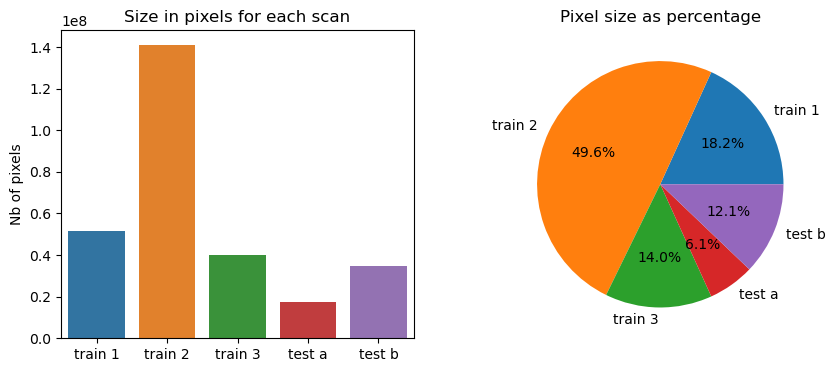

Shape Nb of pixels
train 1   (8181, 6330)     51785730
train 2  (14830, 9506)    140973980
train 3   (7606, 5249)     39923894
test a    (2727, 6330)     17261910
test b    (5454, 6330)     34523820

In [5]:
df = get_shape_info()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=df.index, y=df['Nb of pixels'], )
plt.title("Size in pixels for each scan")
plt.subplot(1, 2, 2)
plt.pie(df['Nb of pixels'], labels=df.index, autopct='%0.1f%%')
plt.title("Pixel size as percentage")
plt.show()

df

### Insights
- As we can see, the images have **different sizes** in terms of the number of pixels
- Train 2 is the largest (almost 50% of the total size), while the scan a in the test set is the smallest.
- The images in the **training set are landscape oriented** (width is larger than height)
- The images in the **test set are portray oriented** (height is larger than width)

# Infrareds, Inklabels and Masks
The dataset also includes PNG files, but only the train set contains "ir" and "inklabels" files since these are information about **what we want to predict.** The masks are binary images that delimit the scroll from the background.

**Let's look at all of these files.**

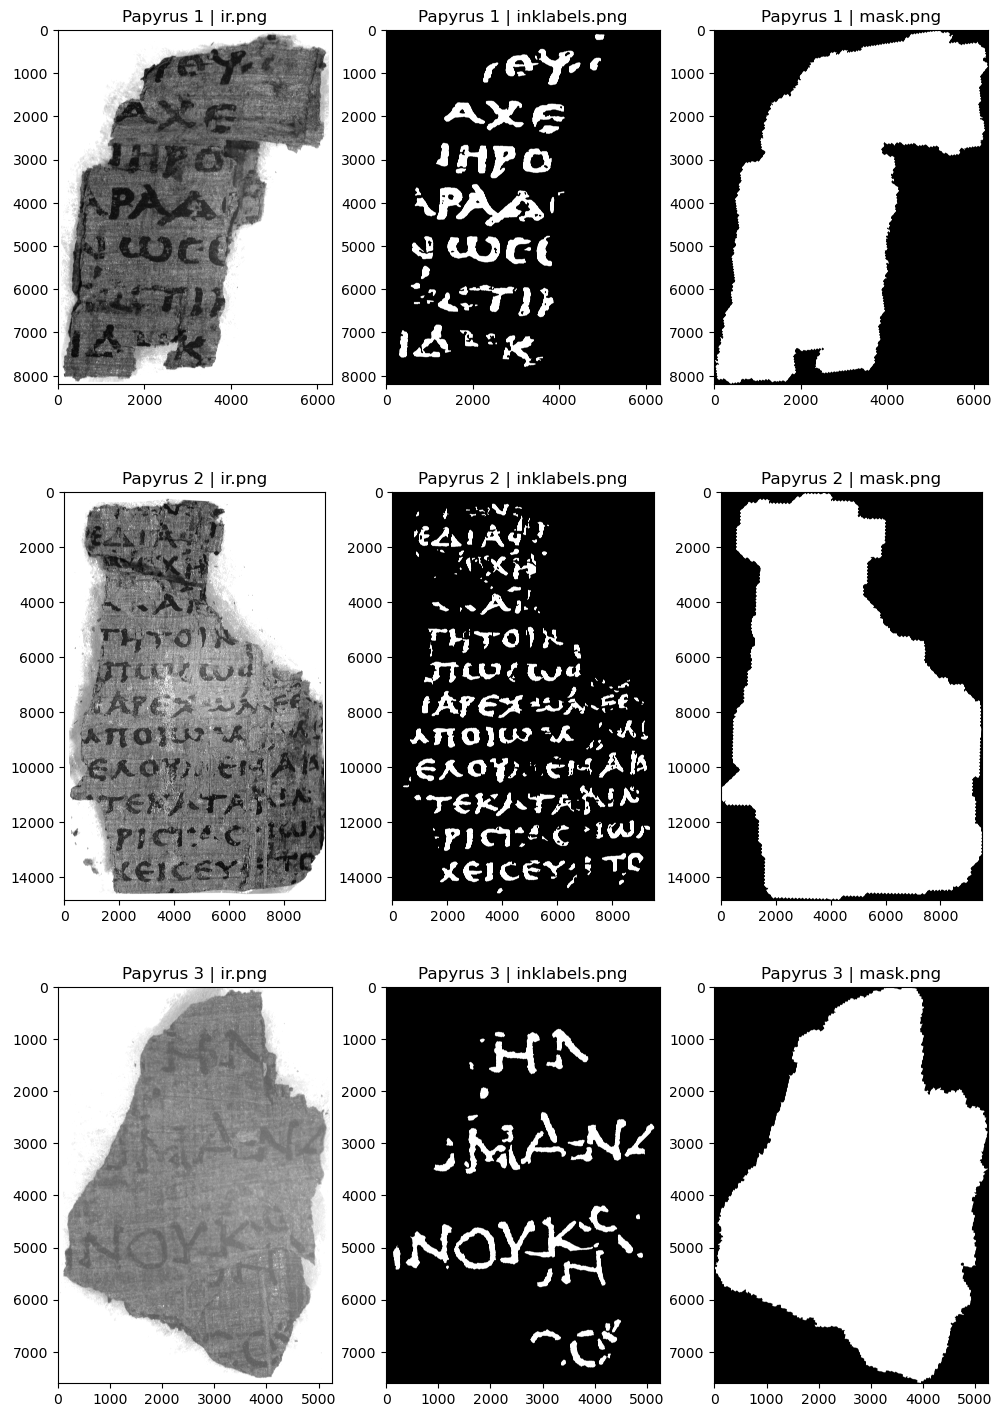

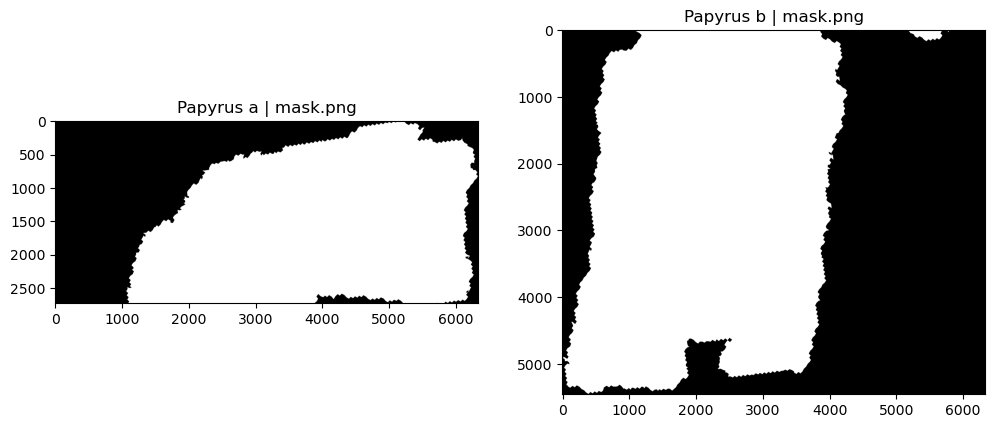

In [6]:
def display_png_files():
    # Train set
    files = ['ir.png', 'inklabels.png', 'mask.png']
    plt.figure(figsize=(12, 18))
    k = 1
    for i in range(1, 4):
        folder = f'/kaggle/input/vesuvius-challenge-ink-detection/train/{i}/'
        for file in files:
            filepath = folder + file
            img = cv2.imread(filepath, cv2.IMREAD_ANYDEPTH)
            plt.subplot(3, 3, k)
            plt.imshow(img, cmap='gray')
            plt.title(f"Papyrus {i} | {file}")
            k += 1
    plt.show()
    
    # Test set
    plt.figure(figsize=(12, 9))
    for k, a in enumerate(['a', 'b']):
        filepath = f'/kaggle/input/vesuvius-challenge-ink-detection/test/{a}/mask.png'
        img = cv2.imread(filepath, cv2.IMREAD_ANYDEPTH)
        img.shape
        plt.subplot(1, 2, k+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Papyrus {a} | mask.png")
    plt.show()
        
display_png_files()

### Insights
- The **masks** define the **boundary** between the papyrus scroll and the background.
- The infrared files reveal the ink on the paper, which is then used to create the label images.
- The label images are **binary images** where white pixels indicate the location of the ink.

# How much space takes the ink
The task is binary segmentation, aimed at identifying the locations of ink on the paper. Each pixel on the paper can have a value of either 0 or 1.

We will **calculate the proportion of paper covered by ink** for each papyrus scroll using the masks and ink labels.

# ================= SOON =====================

# Look at the scan volums

## - Train 1

In [7]:
display_volume('train', '1')

  0%|          | 0/65 [00:00<?, ?it/s]

## - Train 2

In [8]:
display_volume('train', '2')

  0%|          | 0/65 [00:00<?, ?it/s]

## - Train 3

In [9]:
display_volume('train', '3')

  0%|          | 0/65 [00:00<?, ?it/s]

## - Test a

In [10]:
display_volume('test', 'a')

  0%|          | 0/65 [00:00<?, ?it/s]

## - Test b

In [11]:
display_volume('test', 'b')

  0%|          | 0/65 [00:00<?, ?it/s]